# Exploratory Data Analysis (EDA) for Septicemia Risk Prediction

This notebook performs EDA on the CMS SynPUF dataset to inform feature engineering for the septicemia risk prediction pipeline. Objectives:
- Analyze beneficiary demographics (age, sex, chronic conditions).
- Identify top ICD-9 and HCPCS codes in claims data.
- Examine claim counts and payment amounts by file type (inpatient, outpatient, carrier).
- Generate visualizations and save results to `data/processed/septicemia_risk/eda/`.

## Setup
Use Dask for scalability, PyArrow for efficient CSV reading, and logging to track progress.

In [5]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import sys

# Add project root to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.utils import setup_logger

# Initialize logger
logger = setup_logger(log_dir=os.path.join(project_root, 'outputs/logs'), log_file='eda.log')
logger.info('Starting EDA notebook')

# Set output directory
output_dir = os.path.join(project_root, 'data/processed/septicemia_risk/eda')
os.makedirs(output_dir, exist_ok=True)

# Configure plotting
plt.style.use('seaborn-v0_8-notebook')
%matplotlib inline

SynPUFPipeline - INFO - Starting EDA notebook


## Load Data
Load beneficiary and claims data using Dask with PyArrow backend.

In [6]:
# Define dtypes
BENEFICIARY_DTYPES = {
    'DESYNPUF_ID': str,
    'BENE_BIRTH_DT': str,
    'BENE_SEX_IDENT_CD': str,
    'SP_STATE_CODE': str,
    'BENE_HI_CVRAGE_TOT_MONS': 'int32',
    'SP_ALZHDMTA': 'int8',
    'SP_CHF': 'int8',
    'SP_CHRNKIDN': 'int8',
    'SP_CNCR': 'int8',
    'SP_COPD': 'int8',
    'SP_DEPRESSN': 'int8',
    'SP_DIABETES': 'int8',
    'SP_ISCHMCHT': 'int8',
    'SP_OSTEOPRS': 'int8',
    'SP_RA_OA': 'int8',
    'SP_STRKETIA': 'int8'
}

CLAIMS_DTYPES = {
    'DESYNPUF_ID': str,
    'CLM_ID': str,
    'CLM_FROM_DT': str,
    'CLM_PMT_AMT': 'float64',
    'ADMTNG_ICD9_DGNS_CD': str,
    **{f'ICD9_DGNS_CD_{i}': str for i in range(1, 11)},
    **{f'HCPCS_CD_{i}': str for i in range(1, 46)},
    **{f'LINE_ICD9_DGNS_CD_{i}': str for i in range(1, 14)},
    **{f'LINE_NCH_PMT_AMT_{i}': 'float64' for i in range(1, 14)}
}

# Load beneficiary data
beneficiary_df = dd.read_csv(
    os.path.join(project_root, 'data/raw/DE1_0_2009_Beneficiary_Summary_File_Sample_1.csv'),
    usecols=list(BENEFICIARY_DTYPES.keys()),
    dtype=BENEFICIARY_DTYPES,
    blocksize=10e6,
    engine='pyarrow'
)
beneficiary_df['age'] = 2009 - dd.to_datetime(beneficiary_df['BENE_BIRTH_DT'], format='%Y%m%d').dt.year
beneficiary_df['age'] = beneficiary_df['age'].fillna(0).astype('int32')
chronic_cols = ['SP_ALZHDMTA', 'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD',
                'SP_DEPRESSN', 'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS',
                'SP_RA_OA', 'SP_STRKETIA']
for col in chronic_cols:
    beneficiary_df[col] = (beneficiary_df[col] == 1).astype('int8')
beneficiary_df['chronic_condition_count'] = beneficiary_df[chronic_cols].sum(axis=1).fillna(0).astype('int32')
logger.info(f'Beneficiary data loaded: {len(beneficiary_df)} rows')
logger.info(f'Beneficiary null counts: {beneficiary_df.isna().sum().compute()}')

# Load claims data
inpatient_df = dd.read_csv(
    os.path.join(project_root, 'data/raw/DE1_0_2008_to_2010_Inpatient_Claims_Sample_1.csv'),
    usecols=['DESYNPUF_ID', 'CLM_ID', 'CLM_FROM_DT', 'CLM_PMT_AMT', 'ADMTNG_ICD9_DGNS_CD'] + 
            [f'ICD9_DGNS_CD_{i}' for i in range(1, 11)] + 
            [f'HCPCS_CD_{i}' for i in range(1, 46)],
    dtype=CLAIMS_DTYPES,
    blocksize=10e6,
    engine='pyarrow'
)
outpatient_df = dd.read_csv(
    os.path.join(project_root, 'data/raw/DE1_0_2008_to_2010_Outpatient_Claims_Sample_1.csv'),
    usecols=['DESYNPUF_ID', 'CLM_ID', 'CLM_FROM_DT', 'CLM_PMT_AMT', 'ADMTNG_ICD9_DGNS_CD'] + 
            [f'ICD9_DGNS_CD_{i}' for i in range(1, 11)] + 
            [f'HCPCS_CD_{i}' for i in range(1, 46)],
    dtype=CLAIMS_DTYPES,
    blocksize=10e6,
    engine='pyarrow'
)
carrier_df = dd.read_csv(
    os.path.join(project_root, 'data/raw/DE1_0_2008_to_2010_Carrier_Claims_Sample_1A.csv'),
    usecols=['DESYNPUF_ID', 'CLM_ID', 'CLM_FROM_DT'] + 
            [f'ICD9_DGNS_CD_{i}' for i in range(1, 9)] + 
            [f'LINE_ICD9_DGNS_CD_{i}' for i in range(1, 14)] + 
            [f'HCPCS_CD_{i}' for i in range(1, 13)] + 
            [f'LINE_NCH_PMT_AMT_{i}' for i in range(1, 14)],
    dtype=CLAIMS_DTYPES,
    blocksize=10e6,
    engine='pyarrow'
)

# Clean claims data
for df, file_type in [(inpatient_df, 'inpatient'), (outpatient_df, 'outpatient'), (carrier_df, 'carrier')]:
    df['CLM_FROM_DT'] = df['CLM_FROM_DT'].str.replace(r'\.0$', '', regex=True).str.strip()
    df['CLM_FROM_DT'] = dd.to_datetime(df['CLM_FROM_DT'], format='%Y%m%d', errors='coerce')
    df = df[~df['CLM_FROM_DT'].isna()].persist()
    icd9_cols = [col for col in df.columns if 'ICD9_DGNS_CD' in col or 'LINE_ICD9_DGNS_CD' in col]
    for col in icd9_cols:
        df[col] = df[col].str.strip().replace('', np.nan).fillna('').astype('string')
    hcpcs_cols = [col for col in df.columns if 'HCPCS_CD' in col]
    for col in hcpcs_cols:
        df[col] = df[col].str.strip().replace('', np.nan).fillna('').astype('string')
    logger.info(f'{file_type}_df null counts: {df.isna().sum().compute()}')

# Sum LINE_NCH_PMT_AMT for carrier claims
carrier_df['CLM_PMT_AMT'] = carrier_df[[f'LINE_NCH_PMT_AMT_{i}' for i in range(1, 14)]].fillna(0).sum(axis=1).astype('float64')
carrier_df = carrier_df.drop(columns=[f'LINE_NCH_PMT_AMT_{i}' for i in range(1, 14)])

# Combine claims
inpatient_df['file_type'] = 'inpatient'
outpatient_df['file_type'] = 'outpatient'
carrier_df['file_type'] = 'carrier'
claims_df = dd.concat([inpatient_df, outpatient_df, carrier_df], axis=0).persist()
logger.info(f'Combined claims_df: {len(claims_df)} rows')
logger.info(f'claims_df null counts: {claims_df.isna().sum().compute()}')

SynPUFPipeline - INFO - Beneficiary data loaded: 114538 rows
SynPUFPipeline - INFO - Beneficiary null counts: DESYNPUF_ID                0
BENE_BIRTH_DT              0
BENE_SEX_IDENT_CD          0
SP_STATE_CODE              0
BENE_HI_CVRAGE_TOT_MONS    0
SP_ALZHDMTA                0
SP_CHF                     0
SP_CHRNKIDN                0
SP_CNCR                    0
SP_COPD                    0
SP_DEPRESSN                0
SP_DIABETES                0
SP_ISCHMCHT                0
SP_OSTEOPRS                0
SP_RA_OA                   0
SP_STRKETIA                0
age                        0
chronic_condition_count    0
dtype: int64
SynPUFPipeline - INFO - inpatient_df null counts: DESYNPUF_ID            0
CLM_ID                 0
CLM_FROM_DT            0
CLM_PMT_AMT            0
ADMTNG_ICD9_DGNS_CD    0
ICD9_DGNS_CD_1         0
ICD9_DGNS_CD_2         0
ICD9_DGNS_CD_3         0
ICD9_DGNS_CD_4         0
ICD9_DGNS_CD_5         0
ICD9_DGNS_CD_6         0
ICD9_DGNS_CD_7         0
ICD9_

In [100]:
claims_df.head()

,DESYNPUF_ID,CLM_ID,CLM_FROM_DT,CLM_PMT_AMT,ADMTNG_ICD9_DGNS_CD,ICD9_DGNS_CD_1,ICD9_DGNS_CD_2,ICD9_DGNS_CD_3,ICD9_DGNS_CD_4,ICD9_DGNS_CD_5,...,LINE_ICD9_DGNS_CD_6,LINE_ICD9_DGNS_CD_7,LINE_ICD9_DGNS_CD_8,LINE_ICD9_DGNS_CD_9,LINE_ICD9_DGNS_CD_10,LINE_ICD9_DGNS_CD_11,LINE_ICD9_DGNS_CD_12,LINE_ICD9_DGNS_CD_13,septicemia_case_ind,index_date
0,00013D2EFD8E45D1,196661176988405,2010-03-12,4000.0,4580,7802,78820,V4501,4280,2720,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.0,2009-10-14
1,00016F745862898F,196201177000368,2009-04-12,26000.0,7866,1970,4019,5853,7843,2768,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.0,2009-05-16
2,00016F745862898F,196661177015632,2009-08-31,5000.0,6186,6186,2948,56400,None,None,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.0,2009-05-16
3,00016F745862898F,196091176981058,2009-09-17,5000.0,29590,29623,30390,71690,34590,V1581,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.0,2009-05-16
4,00016F745862898F,196261176983265,2010-06-26,16000.0,5849,3569,4019,3542,V8801,78820,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.0,2009-05-16


## Index Dates
Load datasets with index dates for septicemia cases and outcome status. 

In [9]:
cases_df = pd.read_csv(os.path.join(project_root, 'data/processed/septicemia_risk/septicemia_cases.csv'))
cases_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1073 entries, 0 to 1072
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   DESYNPUF_ID             1073 non-null   object
 1   latest_septicemia_date  1073 non-null   object
dtypes: object(2)
memory usage: 16.9+ KB


In [35]:
def assign_index_dates(septicemia_cases: pd.DataFrame, claims_df: dd.DataFrame,
                      beneficiary_df: dd.DataFrame, start_date: str = '2009-01-01',
                      end_date: str = '2009-12-25') -> dd.DataFrame:
    """
    Assign index dates: latest septicemia date or random 2009 claim date.
    
    Args:
        septicemia_cases (dd.DataFrame): Beneficiaries with septicemia.
        claims_df (dd.DataFrame): Combined claims data.
        beneficiary_df (dd.DataFrame): Beneficiary data.
        start_date (str): Start date for random index (default: 2009-01-01).
        end_date (str): End date for random index (default: 2009-12-25).
    
    Returns:
        dd.DataFrame: DESYNPUF_ID and index_date.
    """
    logger.info("Assigning index dates")
    
    # Filter 2009 claims
    claims_2009 = claims_df[claims_df['CLM_FROM_DT'].dt.year == 2009][['DESYNPUF_ID', 'CLM_FROM_DT']]
    
    # Merge beneficiaries with claims to ensure coverage
    valid_beneficiaries = beneficiary_df[['DESYNPUF_ID']].merge(
        claims_2009[['DESYNPUF_ID']].drop_duplicates(), on='DESYNPUF_ID', how='inner'
    )
    
    # Assign latest septicemia date for septicemia cases
    septicemia_index = septicemia_cases.rename(columns={'latest_septicemia_date': 'index_date'})
    septicemia_index['septicemia_case_ind'] = 1
    
    # For non-septicemia beneficiaries, sample random 2009 claim date
    non_septicemia = valid_beneficiaries[~valid_beneficiaries['DESYNPUF_ID'].isin(septicemia_cases['DESYNPUF_ID'])]
    non_septicemia = non_septicemia.merge(claims_2009, on='DESYNPUF_ID')
    non_septicemia = non_septicemia[
        (non_septicemia['CLM_FROM_DT'] >= start_date) &
        (non_septicemia['CLM_FROM_DT'] <= end_date)
    ]
    
    # Randomly sample one date per beneficiary
    non_septicemia_index = non_septicemia.groupby('DESYNPUF_ID').apply(
        lambda x: x.sample(n=1, random_state=42)[['CLM_FROM_DT']],
        meta={'CLM_FROM_DT': 'datetime64[ns]'},
        include_groups=True
    ).reset_index().rename(columns={'index':'DESYNPUF_ID','CLM_FROM_DT': 'index_date'})[['DESYNPUF_ID', 'index_date']]
    non_septicemia_index['septicemia_case_ind'] = 0 # Add case indicators
    
    # Combine septicemia and non-septicemia index dates
    index_dates = dd.concat([septicemia_index, non_septicemia_index], axis=0)[['DESYNPUF_ID', 'septicemia_case_ind', 'index_date']]
    
    # # Save intermediate result
    # output_path = os.path.join(project_root, 'data/processed/septicemia_risk/index_dates.csv')
    # index_dates.to_csv(output_path, single_file=True, index=False)
    # logger.info(f"Assigned index dates for {len(index_dates)} beneficiaries, saved to {output_path}")
    
    return index_dates.compute()

In [36]:
index_dates = assign_index_dates(cases_df,claims_df,beneficiary_df)
index_dates.info()

SynPUFPipeline - INFO - Assigning index dates


<class 'pandas.core.frame.DataFrame'>
Index: 83012 entries, 0 to 555
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   DESYNPUF_ID          83012 non-null  object
 1   septicemia_case_ind  83012 non-null  int64 
 2   index_date           83012 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.5+ MB


In [38]:
index_dates.septicemia_case_ind.value_counts()

septicemia_case_ind
0    81939
1     1073
Name: count, dtype: int64

## Condense ICD and HCPCS features

1) Filter claims to 30 days prior to index date
2) Extract ICD/HCPCS codes from relevant columns
3) Explode to one row per ID

In [48]:
# claims_df.drop(columns=['septicemia_case_ind','index_date'],inplace=True)

from datetime import timedelta

# Step 1: Filter claims to lookback period (assuming 30 days)
claims_df = claims_df.merge(index_dates, on='DESYNPUF_ID', how='left')
claims_df['index_date'] = pd.to_datetime(claims_df['index_date'],errors='coerce')
lookback_days = 30
claims_window = claims_df[
    (claims_df['CLM_FROM_DT'] >= claims_df['index_date'] - timedelta(days=lookback_days)) &
    (claims_df['CLM_FROM_DT'] < claims_df['index_date'])
]

### ICD Codes

In [117]:
# Step 2: Extract all ICD codes from relevant columns
icd_cols = [col for col in claims_window.columns if 'ICD9_DGNS_CD' in col]
claims_window['icd_list'] = claims_window[icd_cols].apply(
    lambda row: [code for code in row if pd.notnull(code) and code != '' and code != None and code != "None"],
    axis=1,
    # meta=('icd_list', 'object')
)

# Step 3: Explode to one row per ICD code per claim
claims_exploded = claims_window[['DESYNPUF_ID','septicemia_case_ind', 'icd_list']].explode('icd_list').rename(columns={'icd_list': 'ICD_code'})
claims_exploded = claims_exploded[claims_exploded['ICD_code'].notnull()]

# Step 4: Compute prevalence and frequency in long format
# Prevalence: 1 if ICD code is present for the patient, 0 otherwise
prevalence = claims_exploded.groupby(['DESYNPUF_ID','septicemia_case_ind','ICD_code']).size().reset_index().rename(columns={0: 'count'})
prevalence['present'] = (prevalence['count'] > 0).astype('int8')
prevalence = prevalence[['DESYNPUF_ID', 'septicemia_case_ind', 'ICD_code', 'present']]

# pivot to wide
prevalence_wide = prevalence.pivot_table(
    index=['DESYNPUF_ID','septicemia_case_ind'], 
    columns='ICD_code', 
    values='present',
    aggfunc='max'
).fillna(0).astype('int8')

# Frequency: Total count of each ICD code per patient
frequency = claims_exploded.groupby(['DESYNPUF_ID','septicemia_case_ind', 'ICD_code']).size().reset_index().rename(columns={0: 'frequency'})

# pivot to wide
frequency_wide = frequency.pivot_table(
    index=['DESYNPUF_ID','septicemia_case_ind'], 
    columns='ICD_code', 
    values='frequency',
    aggfunc='sum'
).fillna(0).astype('int32')

In [75]:
prevalence_wide.shape # only captured 40300 vs 83012 starting. Expected?

(40300, 9160)

In [121]:
icd_prevalence_diff = prevalence_wide.groupby('septicemia_case_ind').mean().T.reset_index()
icd_prevalence_diff['prev_diff'] = icd_prevalence_diff[1.0] - icd_prevalence_diff[0.0]#.replace(0, np.nan)
icd_prevalence_diff['prev_ratio'] = icd_prevalence_diff[1.0] / icd_prevalence_diff[0.0].replace(0, np.nan)
icd_prevalence_diff.sort_values('prev_diff', ascending=False)

septicemia_case_ind,ICD_code,0.0,1.0,prev_diff,prev_ratio
3464,4019,0.202555,0.273517,0.070962,1.350333
1688,28521,0.019869,0.068017,0.048148,3.423253
3650,4280,0.055467,0.099855,0.044388,1.800258
4667,58881,0.013330,0.053546,0.040215,4.016832
4742,5990,0.046833,0.083936,0.037104,1.792255
...,...,...,...,...,...
2797,36616,0.020450,0.011577,-0.008872,0.566136
5372,7140,0.013255,0.004342,-0.008913,0.327550
9158,nan,0.023606,0.014472,-0.009134,0.613062
1535,2722,0.034967,0.024602,-0.010365,0.703582


In [171]:
icd_prevalence_diff[icd_prevalence_diff.ICD_code == '4019']

septicemia_case_ind,ICD_code,0.0,1.0,prev_diff,prev_ratio
3464,4019,0.202555,0.273517,0.070962,1.350333


In [139]:
# these seem promising
# at least 1% increase in prevalence, >2x more prevalent in positive cases
icd_prev = icd_prevalence_diff[(icd_prevalence_diff['prev_diff'] > 0.01)&(icd_prevalence_diff['prev_ratio'] > 2)].ICD_code.tolist()

In [99]:
# investigate frequency differences

10.73

In [132]:
icd_frequency_diff = frequency_wide.groupby('septicemia_case_ind').mean().T.reset_index()
icd_frequency_diff['freq_diff'] = icd_frequency_diff[1.0] - icd_frequency_diff[0.0]#.replace(0, np.nan)
icd_frequency_diff['freq_ratio'] = icd_frequency_diff[1.0] / icd_frequency_diff[0.0]#.replace(0, np.nan)
icd_frequency_diff.sort_values('freq_diff', ascending=False)

septicemia_case_ind,ICD_code,0.0,1.0,freq_diff,freq_ratio
4660,5856,0.040521,0.143271,0.102750,3.535705
3464,4019,0.282436,0.364689,0.082253,1.291227
1688,28521,0.032568,0.111433,0.078864,3.421502
4137,51881,0.022419,0.092619,0.070200,4.131263
3650,4280,0.075766,0.140376,0.064611,1.852770
...,...,...,...,...,...
1533,2720,0.085486,0.066570,-0.018915,0.778730
5372,7140,0.023606,0.004342,-0.019264,0.183919
1535,2722,0.047742,0.027496,-0.020245,0.575941
3463,4011,0.197935,0.176556,-0.021379,0.891989


In [137]:
icd_frequency_diff['freq_diff'].describe()

count    9159.000000
mean        0.000294
std         0.003071
min        -0.030921
25%        -0.000232
50%        -0.000076
75%        -0.000025
max         0.102750
Name: freq_diff, dtype: float64

In [138]:
icd_freq = icd_frequency_diff[(icd_frequency_diff['freq_diff'] > 0.01)&(icd_frequency_diff['freq_ratio'] > 2)].ICD_code.tolist()

In [143]:
# combine
icd_list = list(set(icd_prev) | set(icd_freq))
icd_list

['40390',
 '585',
 '7993',
 '78603',
 '9583',
 'V5881',
 '56211',
 '40391',
 '27651',
 '135',
 '51881',
 '5070',
 'V420',
 '72703',
 '5849',
 '3051',
 '79430',
 'V561',
 '2851',
 '79902',
 'V5789',
 'V053',
 '42823',
 '6826',
 'V560',
 '2662',
 '2639',
 '481',
 '99673',
 '41519',
 '2762',
 '486',
 '1890',
 '2819',
 '78791',
 '2761',
 '4139',
 '4281',
 'V726',
 '5854',
 '70703',
 '78701',
 '29653',
 '44021',
 '5856',
 '78009',
 '58881',
 '43491',
 '72981',
 '72402',
 '0389',
 '2948',
 '7837',
 '4275',
 '2809',
 '78097',
 '8208',
 '2767',
 '28521',
 '72885',
 '25040',
 '49121']

### HCPCS

In [146]:
# Step 2: Extract all HCPCS codes from relevant columns
hcpcs_cols = [col for col in claims_window.columns if 'HCPCS_CD' in col]
claims_window['hcpcs_list'] = claims_window[hcpcs_cols].apply(
    lambda row: [code for code in row if pd.notnull(code) and code != ''and code != None and code != "None"],
    axis=1,
)

# Step 3: Explode to one row per ICD code per claim
claims_exploded = claims_window[['DESYNPUF_ID','septicemia_case_ind', 'hcpcs_list']].explode('hcpcs_list').rename(columns={'hcpcs_list': 'HCPCS_code'})
claims_exploded = claims_exploded[claims_exploded['HCPCS_code'].notnull()]

# Step 4: Compute prevalence and frequency in long format
# Prevalence: 1 if ICD code is present for the patient, 0 otherwise
prevalence_hcpcs = claims_exploded.groupby(['DESYNPUF_ID','septicemia_case_ind','HCPCS_code']).size().reset_index().rename(columns={0: 'count'})
prevalence_hcpcs['present'] = (prevalence_hcpcs['count'] > 0).astype('int8')
prevalence_hcpcs = prevalence_hcpcs[['DESYNPUF_ID', 'septicemia_case_ind', 'HCPCS_code', 'present']]

# pivot to wide
prevalence_hcpcs_wide = prevalence_hcpcs.pivot_table(
    index=['DESYNPUF_ID','septicemia_case_ind'], 
    columns='HCPCS_code', 
    values='present',
    aggfunc='max'
).fillna(0).astype('int8')

# Frequency: Total count of each ICD code per patient
frequency_hcpcs = claims_exploded.groupby(['DESYNPUF_ID','septicemia_case_ind', 'HCPCS_code']).size().reset_index().rename(columns={0: 'frequency'})

# pivot to wide
frequency_hcpcs_wide = frequency_hcpcs.pivot_table(
    index=['DESYNPUF_ID','septicemia_case_ind'], 
    columns='HCPCS_code', 
    values='frequency',
    aggfunc='sum'
).fillna(0).astype('int32')

In [148]:
hcpcs_prevalence_diff = prevalence_hcpcs_wide.groupby('septicemia_case_ind').mean().T.reset_index()
hcpcs_prevalence_diff['prev_diff'] = hcpcs_prevalence_diff[1.0] - hcpcs_prevalence_diff[0.0]#.replace(0, np.nan)
hcpcs_prevalence_diff['prev_ratio'] = hcpcs_prevalence_diff[1.0] / hcpcs_prevalence_diff[0.0].replace(0, np.nan)
hcpcs_prevalence_diff.sort_values('prev_diff', ascending=False)

septicemia_case_ind,HCPCS_code,0.0,1.0,prev_diff,prev_ratio
3943,nan,0.475288,0.627536,0.152249,1.320330
3207,A4657,0.009531,0.049275,0.039744,5.169992
3902,Q4081,0.009607,0.047826,0.038219,4.978318
3140,A0425,0.028012,0.063768,0.035756,2.276487
2608,90999,0.010669,0.046377,0.035708,4.347002
...,...,...,...,...,...
2631,92135,0.014714,0.004348,-0.010366,0.295495
3498,G8445,0.025585,0.013043,-0.012541,0.509817
3013,98941,0.026014,0.010145,-0.015869,0.389973
3045,99213,0.218253,0.194203,-0.024050,0.889806


In [159]:
hcpcs_prev = hcpcs_prevalence_diff[(hcpcs_prevalence_diff['prev_diff'] > 0.01)&(hcpcs_prevalence_diff['prev_ratio'] > 2)].HCPCS_code.tolist()

In [150]:
hcpcs_frequency_diff = frequency_hcpcs_wide.groupby('septicemia_case_ind').mean().T.reset_index()
hcpcs_frequency_diff['freq_diff'] = hcpcs_frequency_diff[1.0] - hcpcs_frequency_diff[0.0]#.replace(0, np.nan)
hcpcs_frequency_diff['freq_ratio'] = hcpcs_frequency_diff[1.0] / hcpcs_frequency_diff[0.0]#.replace(0, np.nan)
hcpcs_frequency_diff.sort_values('freq_diff', ascending=False)

septicemia_case_ind,HCPCS_code,0.0,1.0,freq_diff,freq_ratio
3943,nan,2.591505,8.282609,5.691103,3.196061
3207,A4657,0.101302,0.508696,0.407394,5.021576
3902,Q4081,0.097813,0.497101,0.399288,5.082152
2608,90999,0.091341,0.442029,0.350688,4.839318
3683,J2501,0.055518,0.268116,0.212598,4.829383
...,...,...,...,...,...
2044,83036,0.047807,0.036232,-0.011575,0.757881
3498,G8445,0.028290,0.014493,-0.013797,0.512297
3013,98941,0.032208,0.010145,-0.022063,0.314978
3045,99213,0.257161,0.234783,-0.022378,0.912979


In [157]:
hcpcs_frequency_diff[(hcpcs_frequency_diff['freq_diff'] > 0.005)].sort_values('freq_ratio', ascending=False)

septicemia_case_ind,HCPCS_code,0.0,1.0,freq_diff,freq_ratio
1675,75790,0.000657,0.005797,0.005140,8.819398
3426,G0317,0.000708,0.005797,0.005089,8.189441
3588,J0882,0.003110,0.020290,0.017180,6.524920
3209,A4913,0.003868,0.021739,0.017871,5.620205
3701,J2916,0.004803,0.026087,0.021284,5.430892
...,...,...,...,...,...
1878,80053,0.125319,0.147826,0.022507,1.179597
853,36415,0.296903,0.346377,0.049474,1.166633
3046,99214,0.179927,0.202899,0.022972,1.127673
1875,80048,0.068714,0.076812,0.008097,1.117838


In [158]:
hcpcs_freq = hcpcs_frequency_diff[(hcpcs_frequency_diff['freq_diff'] > 0.01)&(hcpcs_frequency_diff['freq_ratio'] > 2)].dropna().HCPCS_code.tolist()

In [160]:
# combine
hcpcs_list = list(set(hcpcs_prev) | set(hcpcs_freq))
hcpcs_list

['90945',
 '93307',
 'Q4081',
 '90999',
 'J0882',
 'A0425',
 '99291',
 'nan',
 'J2916',
 'A4913',
 'J2501',
 'P9603',
 '87340',
 '82310',
 '99239',
 'A4657',
 '83970',
 'J1270',
 'J1756',
 '82435',
 'J2405',
 '90960',
 '80162',
 '82728']

## Beneficiary Demographics
Analyze age, sex, and chronic conditions.

In [69]:
# Age distribution
age_stats = beneficiary_df['age'].describe().compute()
logger.info(f'Age statistics: {age_stats}')

plt.figure(figsize=(10, 6))
sns.histplot(beneficiary_df['age'].compute(), bins=30, kde=True)
plt.title('Age Distribution of Beneficiaries')
plt.xlabel('Age')
plt.ylabel('Count')
plt.savefig(os.path.join(output_dir, 'age_distribution.png'))
plt.close()

# Sex distribution
sex_counts = beneficiary_df['BENE_SEX_IDENT_CD'].value_counts().compute()
logger.info(f'Sex distribution: {sex_counts}')

plt.figure(figsize=(6, 6))
sex_counts.plot(kind='bar')
plt.title('Sex Distribution')
plt.xlabel('Sex (1=Male, 2=Female)')
plt.ylabel('Count')
plt.savefig(os.path.join(output_dir, 'sex_distribution.png'))
plt.close()

# Chronic condition prevalence
chronic_prevalence = beneficiary_df[chronic_cols].mean().compute() * 100
logger.info(f'Chronic condition prevalence (%): {chronic_prevalence}')

plt.figure(figsize=(12, 6))
chronic_prevalence.sort_values(ascending=False).plot(kind='bar')
plt.title('Chronic Condition Prevalence')
plt.xlabel('Condition')
plt.ylabel('Prevalence (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'chronic_condition_prevalence.png'))
plt.close()

SynPUFPipeline - INFO - Age statistics: count    114538.000000
mean         72.629983
std          12.534732
min          26.000000
25%          67.000000
50%          73.000000
75%          81.000000
max         100.000000
Name: age, dtype: float64
SynPUFPipeline - INFO - Sex distribution: BENE_SEX_IDENT_CD
1    51194
2    63344
Name: count, dtype: int64[pyarrow]
SynPUFPipeline - INFO - Chronic condition prevalence (%): SP_ALZHDMTA    23.052611
SP_CHF         34.432241
SP_CHRNKIDN    20.707538
SP_CNCR         8.151007
SP_COPD        15.649828
SP_DEPRESSN    24.520247
SP_DIABETES    41.653425
SP_ISCHMCHT    47.670642
SP_OSTEOPRS    19.127277
SP_RA_OA       17.456215
SP_STRKETIA     5.264628
dtype: float64


In [ ]:
# split by septicemia status

## Claims Analysis
Analyze claim counts, payment amounts, and top ICD-9/HCPCS codes.

SynPUFPipeline - INFO - Computing average claim counts per beneficiary by file type and cohort
SynPUFPipeline - INFO - Average claim counts by file type and cohort:    septicemia_case_ind   file_type  claim_count
0                  0.0     carrier     2.481963
1                  0.0   inpatient     1.054181
2                  0.0  outpatient     1.246565
3                  1.0     carrier     3.074830
4                  1.0   inpatient     1.045045
5                  1.0  outpatient     1.337838


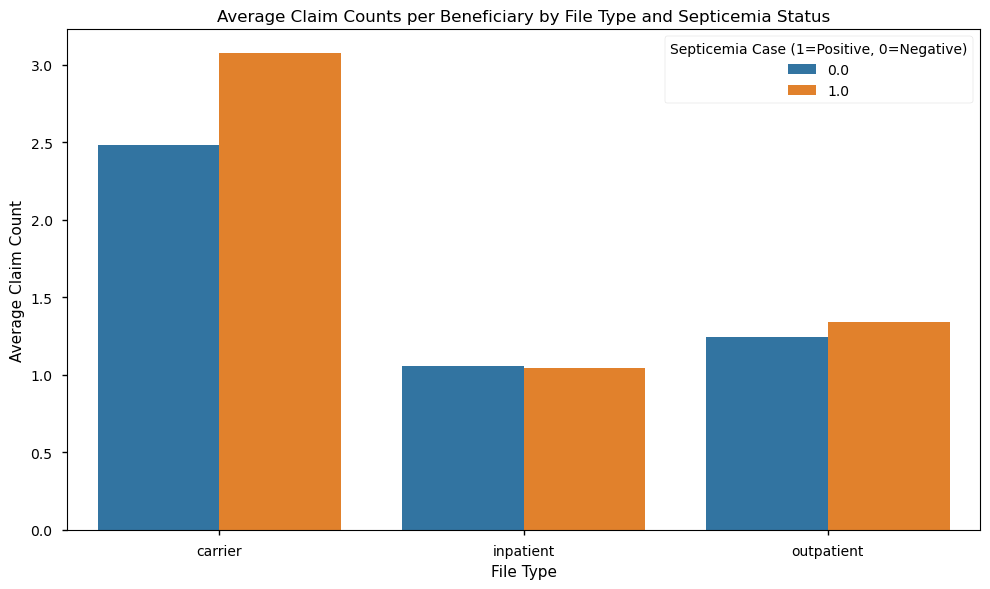

In [165]:
# 1. Average Claim Counts by File Type and Cohort
logger.info("Computing average claim counts per beneficiary by file type and cohort")
claim_counts_per_bene = claims_window.groupby(['DESYNPUF_ID', 'septicemia_case_ind', 'file_type'])['CLM_ID'].count().reset_index().rename(columns={'CLM_ID': 'claim_count'})
average_claims = claim_counts_per_bene.groupby(['septicemia_case_ind', 'file_type'])['claim_count'].mean().reset_index()
logger.info(f'Average claim counts by file type and cohort: {average_claims}')

plt.figure(figsize=(10, 6))
sns.barplot(data=average_claims, x='file_type', y='claim_count', hue='septicemia_case_ind')
plt.title('Average Claim Counts per Beneficiary by File Type and Septicemia Status')
plt.xlabel('File Type')
plt.ylabel('Average Claim Count')
plt.legend(title='Septicemia Case (1=Positive, 0=Negative)')
plt.tight_layout()
plt.show()

SynPUFPipeline - INFO - Computing average spend per beneficiary by file type and cohort
SynPUFPipeline - INFO - Average spend by file type and cohort:    septicemia_case_ind   file_type   total_spend
0                  0.0     carrier    220.287411
1                  0.0   inpatient  10313.398115
2                  0.0  outpatient    339.188714
3                  1.0     carrier    297.777778
4                  1.0   inpatient  11225.225225
5                  1.0  outpatient    511.729730


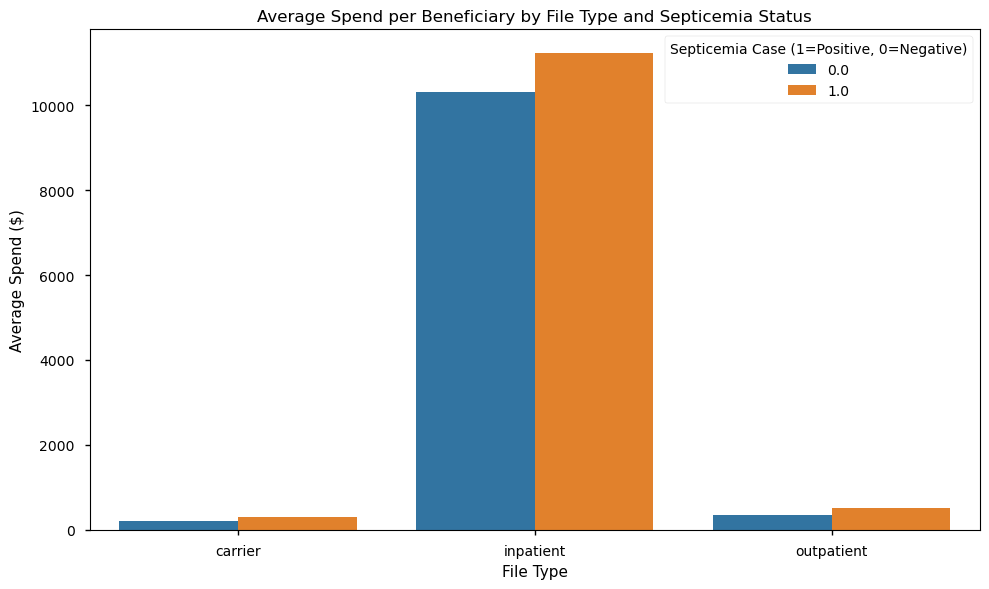

In [167]:
# 2. Average Spend by File Type and Cohort
logger.info("Computing average spend per beneficiary by file type and cohort")
spend_per_bene = claims_window.groupby(['DESYNPUF_ID', 'septicemia_case_ind', 'file_type'])['CLM_PMT_AMT'].sum().reset_index().rename(columns={'CLM_PMT_AMT': 'total_spend'})
average_spend = spend_per_bene.groupby(['septicemia_case_ind', 'file_type'])['total_spend'].mean().reset_index()
logger.info(f'Average spend by file type and cohort: {average_spend}')

plt.figure(figsize=(10, 6))
sns.barplot(data=average_spend, x='file_type', y='total_spend', hue='septicemia_case_ind')
plt.title('Average Spend per Beneficiary by File Type and Septicemia Status')
plt.xlabel('File Type')
plt.ylabel('Average Spend ($)')
plt.legend(title='Septicemia Case (1=Positive, 0=Negative)')
plt.tight_layout()
plt.show()

SynPUFPipeline - INFO - Analyzing top ICD-9 codes by prevalence difference


<Figure size 1200x600 with 0 Axes>

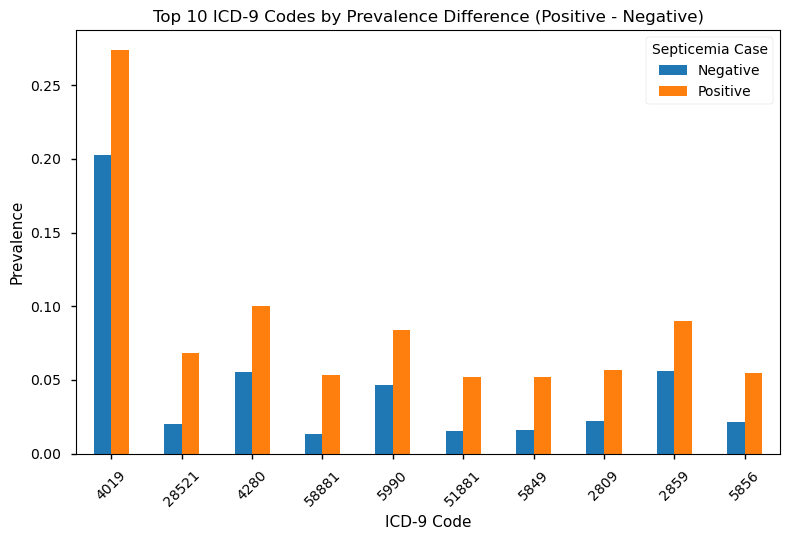

In [170]:
# 3. Top ICD-9 Codes by Prevalence Difference
logger.info("Analyzing top ICD-9 codes by prevalence difference")
icd9_cols = [col for col in claims_window.columns if 'ICD9_DGNS_CD' in col or 'LINE_ICD9_DGNS_CD' in col]
icd_melted = claims_window[['DESYNPUF_ID', 'septicemia_case_ind'] + icd9_cols].melt(
    id_vars=['DESYNPUF_ID', 'septicemia_case_ind'], 
    value_vars=icd9_cols, 
    value_name='ICD_code'
)
icd_melted = icd_melted[icd_melted['ICD_code'].notnull() & (icd_melted['ICD_code'] != '') & (icd_melted['ICD_code'] != 'None')]
icd_unique = icd_melted[['DESYNPUF_ID', 'septicemia_case_ind', 'ICD_code']].drop_duplicates()

# Compute prevalence
code_counts = icd_unique.groupby(['septicemia_case_ind', 'ICD_code'])['DESYNPUF_ID'].nunique().reset_index().rename(columns={'DESYNPUF_ID': 'n_beneficiaries'})
total_beneficiaries = claims_window[['DESYNPUF_ID', 'septicemia_case_ind']].drop_duplicates().groupby('septicemia_case_ind')['DESYNPUF_ID'].nunique().reset_index().rename(columns={'DESYNPUF_ID': 'total_beneficiaries'})
code_counts = code_counts.merge(total_beneficiaries, on='septicemia_case_ind')
code_counts['prevalence'] = code_counts['n_beneficiaries'] / code_counts['total_beneficiaries']

# Pivot and find top differences
prevalence_pivot = code_counts.pivot_table(index='ICD_code', columns='septicemia_case_ind', values='prevalence').fillna(0)
prevalence_pivot['difference'] = prevalence_pivot[1] - prevalence_pivot[0]
top_icd9 = prevalence_pivot.sort_values('difference', ascending=False).head(10)

plt.figure(figsize=(12, 6))
top_icd9[[0, 1]].rename(columns={0: 'Negative', 1: 'Positive'}).plot(kind='bar')
plt.title('Top 10 ICD-9 Codes by Prevalence Difference (Positive - Negative)')
plt.xlabel('ICD-9 Code')
plt.ylabel('Prevalence')
plt.legend(title='Septicemia Case')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

SynPUFPipeline - INFO - Analyzing top HCPCS codes by prevalence difference


<Figure size 1200x600 with 0 Axes>

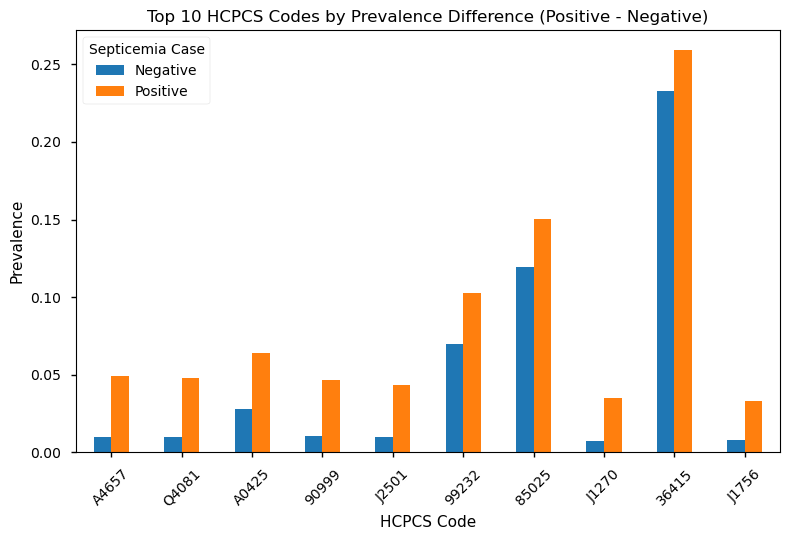

In [174]:
# 4. Top HCPCS Codes by Prevalence Difference
logger.info("Analyzing top HCPCS codes by prevalence difference")
hcpcs_cols = [col for col in claims_window.columns if 'HCPCS_CD' in col]
hcpcs_melted = claims_window[['DESYNPUF_ID', 'septicemia_case_ind'] + hcpcs_cols].melt(
    id_vars=['DESYNPUF_ID', 'septicemia_case_ind'], 
    value_vars=hcpcs_cols, 
    value_name='HCPCS_code'
)
hcpcs_melted = hcpcs_melted[hcpcs_melted['HCPCS_code'].notnull() & (hcpcs_melted['HCPCS_code'] != '') & (hcpcs_melted['HCPCS_code'] != 'nan')]
hcpcs_unique = hcpcs_melted[['DESYNPUF_ID', 'septicemia_case_ind', 'HCPCS_code']].drop_duplicates()

# Compute prevalence
hcpcs_counts = hcpcs_unique.groupby(['septicemia_case_ind', 'HCPCS_code'])['DESYNPUF_ID'].nunique().reset_index().rename(columns={'DESYNPUF_ID': 'n_beneficiaries'})
hcpcs_counts = hcpcs_counts.merge(total_beneficiaries, on='septicemia_case_ind')
hcpcs_counts['prevalence'] = hcpcs_counts['n_beneficiaries'] / hcpcs_counts['total_beneficiaries']

# Pivot and find top differences
hcpcs_pivot = hcpcs_counts.pivot_table(index='HCPCS_code', columns='septicemia_case_ind', values='prevalence').fillna(0)
hcpcs_pivot['difference'] = hcpcs_pivot[1] - hcpcs_pivot[0]
top_hcpcs = hcpcs_pivot.sort_values('difference', ascending=False).head(10)

plt.figure(figsize=(12, 6))
top_hcpcs[[0, 1]].rename(columns={0: 'Negative', 1: 'Positive'}).plot(kind='bar')
plt.title('Top 10 HCPCS Codes by Prevalence Difference (Positive - Negative)')
plt.xlabel('HCPCS Code')
plt.ylabel('Prevalence')
plt.legend(title='Septicemia Case')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Septicemia-Specific Analysis
Analyze claims with ICD-9 code 0389 (septicemia).

In [ ]:
# Filter septicemia claims
septicemia_df = inpatient_df
for i, col in enumerate([f'ICD9_DGNS_CD_{i}' for i in range(1, 11)] + ['ADMTNG_ICD9_DGNS_CD']):
    septicemia_df[f'is_septicemia_{i}'] = (septicemia_df[col] == '0389').astype('int8')
septicemia_cols = [f'is_septicemia_{i}' for i in range(len([f'ICD9_DGNS_CD_{i}' for i in range(1, 11)] + ['ADMTNG_ICD9_DGNS_CD']))]
septicemia_df['septicemia_present'] = septicemia_df[septicemia_cols].sum(axis=1).fillna(0).astype('int32')
septicemia_df = septicemia_df[septicemia_df['septicemia_present'] > 0][['DESYNPUF_ID', 'CLM_FROM_DT', 'CLM_PMT_AMT']]
logger.info(f'Septicemia claims: {len(septicemia_df)} rows')

# Septicemia payment distribution
septicemia_pmt_stats = septicemia_df['CLM_PMT_AMT'].describe().compute()
logger.info(f'Septicemia payment stats: {septicemia_pmt_stats}')

plt.figure(figsize=(10, 6))
sns.histplot(septicemia_df['CLM_PMT_AMT'].compute(), bins=50, kde=True)
plt.title('Septicemia Claim Payment Distribution')
plt.xlabel('Payment Amount ($)')
plt.ylabel('Count')
plt.savefig(os.path.join(output_dir, 'septicemia_payment_distribution.png'))
plt.close()